In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [2]:
df = pd.read_parquet('../data/all_data_preprocessed/all_merged.parquet')

In [3]:
df.head(10)

,region_id,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,...,997,998,999,event_1h_ago,event_2h_ago,event_3h_ago,event_6h_ago,event_12h_ago,event_18h_ago,event_24h_ago
0,1,1645740000,6.0,-1.0,2.6,-0.4,81.9,0.0,0.0,126.2,...,0.504,0.477,0.611,0,0,0,0,0,0,0
1,1,1645740000,6.0,-1.0,2.6,-0.4,81.9,0.0,0.0,126.2,...,0.504,0.477,0.611,0,0,0,0,0,0,0
2,1,1645740000,6.0,-1.0,2.6,-0.4,81.9,0.0,0.0,126.2,...,0.504,0.477,0.611,0,0,0,0,0,0,0
3,1,1645740000,6.0,-1.0,2.6,-0.4,81.9,0.0,0.0,126.2,...,0.504,0.477,0.611,0,0,0,0,0,0,0
4,1,1645740000,6.0,-1.0,2.6,-0.4,81.9,0.0,0.0,126.2,...,0.504,0.477,0.611,0,0,0,0,0,0,0
5,1,1645740000,6.0,-1.0,2.6,-0.4,81.9,0.0,0.0,126.2,...,0.504,0.477,0.611,0,0,0,0,0,0,0
6,1,1645740000,6.0,-1.0,2.6,-0.4,81.9,0.0,0.0,126.2,...,0.504,0.477,0.611,0,0,0,0,0,0,0
7,1,1645740000,6.0,-1.0,2.6,-0.4,81.9,0.0,0.0,126.2,...,0.504,0.477,0.611,0,0,0,0,0,0,0
8,1,1645740000,6.0,-1.0,2.6,-0.4,81.9,0.0,0.0,126.2,...,0.504,0.477,0.611,0,0,0,0,0,0,0
9,1,1645740000,6.0,-1.0,2.6,-0.4,81.9,0.0,0.0,126.2,...,0.504,0.477,0.611,0,0,0,0,0,0,0


In [4]:
X = df.drop(columns=['event_all_region','alarms_in_regions','event_3h_ago','event_2h_ago','event_6h_ago','event_12h_ago','event_18h_ago','event_1h_ago'])
y = df['event_all_region']

In [5]:
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))

In [6]:
train_idx, test_idx = splits[-1]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [10]:
y_pred = lr_model.predict(X_test_scaled)

In [11]:
accuracy = accuracy_score(y_test, y_pred)

In [12]:
accuracy

0.8307701202590194

In [13]:
f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.7894316854030433

In [14]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[83432,  2322],
       [15240,  2782]])

In [15]:
y_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

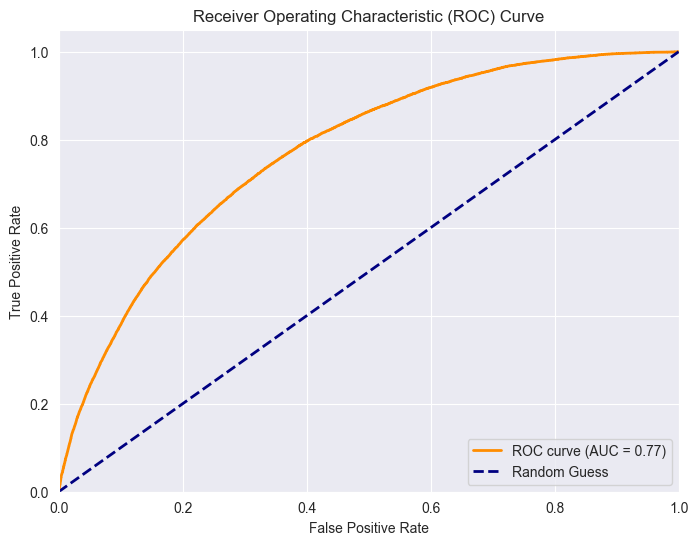

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.85      0.97      0.90     85754
         1.0       0.55      0.15      0.24     18022

    accuracy                           0.83    103776
   macro avg       0.70      0.56      0.57    103776
weighted avg       0.79      0.83      0.79    103776



In [18]:
coefficients = lr_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
})

In [19]:
top_20_features = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False).head(20)

In [20]:
print(top_20_features[['Feature', 'Coefficient', 'Absolute_Coefficient']])

          Feature  Coefficient  Absolute_Coefficient
13     day_sunset    -2.170642              2.170642
12    day_sunrise    -1.895361              1.895361
1018          981    -1.306742              1.306742
876           839     1.305494              1.305494
84             47    -1.304294              1.304294
955           918     1.297383              1.297383
82             45    -1.228185              1.228185
875           838     1.103730              1.103730
983           946     1.053497              1.053497
953           916     1.033842              1.033842
745           708    -1.005445              1.005445
147           110     1.001931              1.001931
987           950     0.988255              0.988255
986           949     0.960635              0.960635
393           356     0.934541              0.934541
392           355    -0.930159              0.930159
233           196    -0.929753              0.929753
418           381     0.921265              0.